In [ ]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from scipy import stats


Iniciando programa CPM...
=== PROGRAMA CPM CON ANÁLISIS DE COSTOS ===

Ingresando actividades predefinidas...

=== RESULTADOS DEL ANÁLISIS CPM ===

ACTIVIDAD  | DURACIÓN | COSTO | IC  | TC  | IL  | TL  | HOLGURA | CRÍTICA
-------------------------------------------------------------------------------------
    A      |   2.0    | 22.0  | 0.0 | 2.0 | 0.0 | 2.0 |   0.0   |   Sí   
    B      |   3.0    | 30.0  | 0.0 | 3.0 | 1.0 | 4.0 |   1.0   |   No   
    C      |   2.0    | 26.0  | 2.0 | 4.0 | 2.0 | 4.0 |   0.0   |   Sí   
    D      |   4.0    | 48.0  | 3.0 | 7.0 | 4.0 | 8.0 |   1.0   |   No   
    E      |   4.0    | 56.0  | 4.0 | 8.0 | 4.0 | 8.0 |   0.0   |   Sí   
    F      |   3.0    | 30.0  | 4.0 | 7.0 | 10.0 | 13.0 |   6.0   |   No   
    G      |   5.0    | 80.0  | 8.0 | 13.0 | 8.0 | 13.0 |   0.0   |   Sí   
    H      |   2.0    | 16.0  | 13.0 | 15.0 | 13.0 | 15.0 |   0.0   |   Sí   

Duración total del proyecto: 15.0 unidades de tiempo

Ruta crítica: A → C → E → G → H

=== 

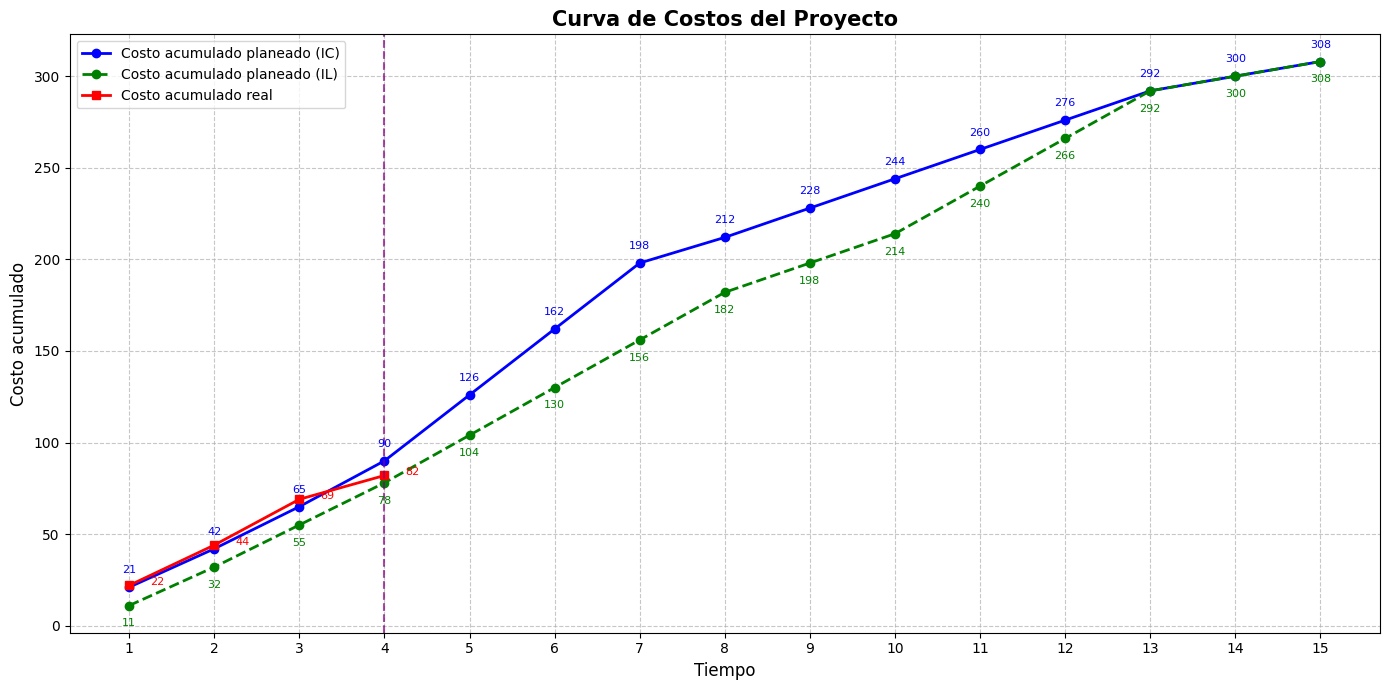

Programa finalizado.


In [ ]:
# CPM--COSTOS--SEGUIMIENTO DE PROYECTO

class ProyectoCPM:
    def __init__(self):
        self.G = nx.DiGraph()
        self.actividades = {}
        self.duracion_proyecto = 0
        self.resultados_cpm = {}
        self.tabla_costos_ic = None  # Tabla de costos con inicio más cercano
        self.tabla_costos_il = None  # Tabla de costos con inicio lejano
        self.costos_acumulados_ic = None
        self.costos_acumulados_il = None
        self.seguimiento = None

    def ingresar_actividades(self):
        """Ingresa actividades manualmente en lugar de solicitar al usuario."""
        print("=== PROGRAMA CPM CON ANÁLISIS DE COSTOS ===")
        print("\nIngresando actividades predefinidas...")

        # Actividad de referencia - puedes usar este formato para agregar más actividades
        self.actividades["A"] = {
            'duracion': 2.0,
            'costo': 22.0,
            'predecesoras': [],
            'avance': 1.0,
            'costo_real': 20.0
        }


        self.actividades["B"] = {
             'duracion': 3.0,
             'costo': 30.0,
             'predecesoras': [],
             'avance': 1.0,
             'costo_real': 36.0
         }

        self.actividades["C"] = {
             'duracion': 2.0,
             'costo': 26.0,
             'predecesoras': ["A"],
             'avance': 1.0,
             'costo_real': 26.0
         }

        self.actividades["D"] = {
             'duracion': 4.0,
             'costo': 48.0,
             'predecesoras': ["B"],
             'avance': 0.1,
             'costo_real': 6.0
         }

        self.actividades["E"] = {
             'duracion': 4.0,
             'costo': 56.0,
             'predecesoras': ["C"],
             'avance': 0.2,
             'costo_real': 20.0
         }

        self.actividades["F"] = {
             'duracion': 3.0,
             'costo': 30.0,
             'predecesoras': ["C"],
             'avance': 0.2,
             'costo_real': 4.0
         }

        self.actividades["G"] = {
             'duracion': 5.0,
             'costo': 80.0,
             'predecesoras': ["D","E"],
             'avance': 0.0,
             'costo_real': 0.0
         }


        self.actividades["H"] = {
             'duracion': 2.0,
             'costo': 16.0,
             'predecesoras': ["F","G"],
             'avance': 0.0,
             'costo_real': 0.0
         }


        # Crear el grafo
        self._crear_grafo()
        return True

    def _crear_grafo(self):
        """Crea el grafo dirigido a partir de las actividades ingresadas."""
        for act, data in self.actividades.items():
            self.G.add_node(act, duracion=data['duracion'], costo=data['costo'])

            for pred in data['predecesoras']:
                self.G.add_edge(pred, act)

    def realizar_analisis_cpm(self):
        """Realiza el análisis CPM completo."""
        # Encontrar orden topológico
        try:
            orden_topologico = list(nx.topological_sort(self.G))
        except nx.NetworkXUnfeasible:
            print("Error: El grafo contiene ciclos. No se puede realizar el cálculo CPM.")
            return False

        # Inicializar diccionarios para almacenar los tiempos
        IC = {act: 0 for act in self.G.nodes()}  # Inicio Cercano (Early Start)
        TC = {act: 0 for act in self.G.nodes()}  # Término Cercano (Early Finish)
        IL = {act: float('inf') for act in self.G.nodes()}  # Inicio Lejano (Late Start)
        TL = {act: float('inf') for act in self.G.nodes()}  # Término Lejano (Late Finish)

        # Cálculo de IC y TC (hacia adelante)
        for act in orden_topologico:
            predecesoras = list(self.G.predecessors(act))
            if predecesoras:
                IC[act] = max(TC[pred] for pred in predecesoras)
            TC[act] = IC[act] + self.G.nodes[act]['duracion']

        # Calcular la duración total del proyecto
        self.duracion_proyecto = max(TC.values())

        # Cálculo de TL y IL (hacia atrás)
        # Inicializar TL para actividades sin sucesores
        for act in self.G.nodes():
            if list(self.G.successors(act)) == []:
                TL[act] = self.duracion_proyecto

        # Recorrer el grafo en orden inverso
        for act in reversed(orden_topologico):
            sucesoras = list(self.G.successors(act))
            if sucesoras:
                TL[act] = min(IL[suc] for suc in sucesoras)
            else:
                TL[act] = self.duracion_proyecto

            IL[act] = TL[act] - self.G.nodes[act]['duracion']

        # Calcular la holgura
        holgura = {act: (TL[act] - TC[act]) for act in self.G.nodes()}

        # Identificar ruta crítica (actividades con holgura cero)
        ruta_critica = [act for act, h in holgura.items() if abs(h) < 1e-9]  # Consideramos valores muy cercanos a cero

        # Almacenar los resultados
        self.resultados_cpm = {
            'IC': IC,
            'TC': TC,
            'IL': IL,
            'TL': TL,
            'holgura': holgura,
            'ruta_critica': ruta_critica
        }

        return True

    def calcular_tabla_costos(self, modo='ambos'):
        """
        Genera la tabla de distribución de costos por periodo.

        Args:
            modo (str): 'ic' para inicio cercano, 'il' para inicio lejano, 'ambos' para ambos
        """
        # Determinar la duración total del proyecto
        duracion_total = int(self.duracion_proyecto) + 1  # +1 porque incluimos desde el tiempo 0

        # Crear los periodos
        actividades_ordenadas = sorted(self.actividades.keys())
        periodos = [f"{i}" for i in range(1, duracion_total)]

        # Calcular para inicio cercano (IC) si es requerido
        if modo in ['ic', 'ambos']:
            df_ic = pd.DataFrame(0, index=actividades_ordenadas, columns=periodos)

            # Distribuir el costo de cada actividad uniformemente durante su duración
            for act, data in self.actividades.items():
                inicio = max(1, int(self.resultados_cpm['IC'][act]) + 1)  # Ajuste para empezar desde periodo 1
                fin = int(self.resultados_cpm['TC'][act]) + 1
                dias_duracion = fin - inicio

                # Evitar división por cero
                if dias_duracion > 0:
                    costo_diario = data['costo'] / dias_duracion
                    for dia in range(inicio, fin):
                        if str(dia) in df_ic.columns:
                            df_ic.at[act, str(dia)] = round(costo_diario, 2)

            # Agregar columna de total por actividad
            df_ic['TOTAL'] = df_ic.sum(axis=1)

            # Calcular total por periodo
            total_por_periodo_ic = df_ic.sum()

            # Crear DataFrame final
            resultado_ic = df_ic.copy()

            # Agregar filas de totales
            resultado_ic.loc['Total por periodo'] = total_por_periodo_ic

            # Calcular totales acumulados
            acumulados_ic = []
            suma_acumulada = 0
            for valor in total_por_periodo_ic:
                suma_acumulada += valor
                acumulados_ic.append(round(suma_acumulada, 2))

            resultado_ic.loc['Total a la fecha'] = acumulados_ic

            # Guardar resultados
            self.tabla_costos_ic = resultado_ic
            self.costos_acumulados_ic = acumulados_ic[:-1]  # Excluir la columna TOTAL

        # Calcular para inicio lejano (IL) si es requerido
        if modo in ['il', 'ambos']:
            df_il = pd.DataFrame(0, index=actividades_ordenadas, columns=periodos)

            # Distribuir el costo de cada actividad uniformemente durante su duración
            for act, data in self.actividades.items():
                inicio = max(1, int(self.resultados_cpm['IL'][act]) + 1)  # Ajuste para empezar desde periodo 1
                fin = int(self.resultados_cpm['TL'][act]) + 1
                dias_duracion = fin - inicio

                # Evitar división por cero
                if dias_duracion > 0:
                    costo_diario = data['costo'] / dias_duracion
                    for dia in range(inicio, fin):
                        if str(dia) in df_il.columns:
                            df_il.at[act, str(dia)] = round(costo_diario, 2)

            # Agregar columna de total por actividad
            df_il['TOTAL'] = df_il.sum(axis=1)

            # Calcular total por periodo
            total_por_periodo_il = df_il.sum()

            # Crear DataFrame final
            resultado_il = df_il.copy()

            # Agregar filas de totales
            resultado_il.loc['Total por periodo'] = total_por_periodo_il

            # Calcular totales acumulados
            acumulados_il = []
            suma_acumulada = 0
            for valor in total_por_periodo_il:
                suma_acumulada += valor
                acumulados_il.append(round(suma_acumulada, 2))

            resultado_il.loc['Total a la fecha'] = acumulados_il

            # Guardar resultados
            self.tabla_costos_il = resultado_il
            self.costos_acumulados_il = acumulados_il[:-1]  # Excluir la columna TOTAL

        return True

    def ingresar_seguimiento(self):
        """Usa los datos de seguimiento ya definidos en las actividades."""
        print("\n=== SEGUIMIENTO DE AVANCE DEL PROYECTO ===")
        print("Usando los datos de avance y costo real ya definidos en cada actividad...")

        # No modificamos los valores porque ya están definidos en la creación de actividades
        # Simplemente mostramos los valores que se están utilizando
        for act, data in self.actividades.items():
            print(f"Actividad {act}: Avance {data['avance']*100:.0f}%, Costo real {data['costo_real']}")

        # Calcular métricas de seguimiento
        self._calcular_metricas_seguimiento()

        return True

    def _calcular_metricas_seguimiento(self):
        """Calcula las métricas de seguimiento para cada actividad."""
        seguimiento = []

        for act, data in self.actividades.items():
            # Calcular el valor del trabajo según el porcentaje de avance
            valor_trabajo = data['costo'] * data['avance']

            # Calcular diferencia entre costo real y valor del trabajo
            diferencia = data['costo_real'] - valor_trabajo

            # Determinar el estado basado en la diferencia
            if abs(diferencia) < 0.01:  # Consideramos diferencias muy pequeñas como "En presupuesto"
                estado = "En presupuesto"
            elif diferencia < 0:
                estado = "Subcosto"
            else:
                estado = "Sobrecosto"

            # Verificar si la actividad está en la ruta crítica
            es_critica = "Sí" if act in self.resultados_cpm['ruta_critica'] else "No"

            # Agregar información de seguimiento para esta actividad
            seguimiento.append({
                'Actividad': act,
                'Costo presupuestado': data['costo'],
                'Avance (%)': data['avance'] * 100,
                'Valor trabajo terminado': round(valor_trabajo, 2),
                'Costo real': data['costo_real'],
                'Diferencia': round(diferencia, 2),
                'Estado': estado,
                'En ruta crítica': es_critica
            })

        # Convertir a DataFrame
        self.seguimiento = pd.DataFrame(seguimiento)

        return self.seguimiento

    def mostrar_resultados_cpm(self):
        """Muestra los resultados del análisis CPM en forma de tabla."""
        print("\n=== RESULTADOS DEL ANÁLISIS CPM ===")
        print("\nACTIVIDAD  | DURACIÓN | COSTO | IC  | TC  | IL  | TL  | HOLGURA | CRÍTICA")
        print("-" * 85)

        for act in sorted(self.actividades.keys()):
            es_critica = "Sí" if act in self.resultados_cpm['ruta_critica'] else "No"
            print(f"{act:^10} | {self.G.nodes[act]['duracion']:^8.1f} | {self.G.nodes[act]['costo']:^5.1f} | "
                  f"{self.resultados_cpm['IC'][act]:^3.1f} | {self.resultados_cpm['TC'][act]:^3.1f} | "
                  f"{self.resultados_cpm['IL'][act]:^3.1f} | {self.resultados_cpm['TL'][act]:^3.1f} | "
                  f"{self.resultados_cpm['holgura'][act]:^7.1f} | {es_critica:^7}")

        print("\nDuración total del proyecto: {:.1f} unidades de tiempo".format(self.duracion_proyecto))
        print("\nRuta crítica: {}".format(" → ".join(self.resultados_cpm['ruta_critica'])))

    def mostrar_tabla_costos(self, modo='ambos'):
        """
        Muestra la(s) tabla(s) de distribución de costos.

        Args:
            modo (str): 'ic' para inicio cercano, 'il' para inicio lejano, 'ambos' para ambos
        """
        # Configurar opciones de visualización
        pd.set_option('display.max_columns', None)
        pd.set_option('display.width', 200)
        pd.set_option('display.precision', 0)
        pd.set_option('display.colheader_justify', 'center')

        # Mostrar tabla de costos con inicio cercano (IC)
        if modo in ['ic', 'ambos'] and self.tabla_costos_ic is not None:
            print("\n=== TABLA DE DISTRIBUCIÓN DE COSTOS (INICIO MÁS CERCANO) ===")

            # Crear una versión estilizada de la tabla para impresión
            styled_df = self.tabla_costos_ic.copy()

            # Reemplazar nombres de columnas - solo usar números
            styled_df.columns = [col if col != 'TOTAL' else col for col in styled_df.columns]

            # Agregar columna de ACTIVIDAD al inicio
            styled_df = styled_df.reset_index()
            styled_df = styled_df.rename(columns={'index': 'ACTIVIDAD'})

            # Imprimir tabla
            print(styled_df.to_string(index=False))
        elif modo in ['ic', 'ambos']:
            print("La tabla de costos con inicio más cercano no ha sido calculada.")

        # Mostrar tabla de costos con inicio lejano (IL)
        if modo in ['il', 'ambos'] and self.tabla_costos_il is not None:
            print("\n=== TABLA DE DISTRIBUCIÓN DE COSTOS (INICIO MÁS LEJANO) ===")

            # Crear una versión estilizada de la tabla para impresión
            styled_df = self.tabla_costos_il.copy()

            # Reemplazar nombres de columnas - solo usar números
            styled_df.columns = [col if col != 'TOTAL' else col for col in styled_df.columns]

            # Agregar columna de ACTIVIDAD al inicio
            styled_df = styled_df.reset_index()
            styled_df = styled_df.rename(columns={'index': 'ACTIVIDAD'})

            # Imprimir tabla
            print(styled_df.to_string(index=False))
        elif modo in ['il', 'ambos']:
            print("La tabla de costos con inicio más lejano no ha sido calculada.")

        # Restaurar opciones de pandas
        pd.reset_option('display.max_columns')
        pd.reset_option('display.width')
        pd.reset_option('display.precision')
        pd.reset_option('display.colheader_justify')

    def mostrar_tabla_seguimiento(self):
        """Muestra la tabla de seguimiento de avance."""
        if self.seguimiento is not None:
            print("\n=== TABLA DE SEGUIMIENTO DE AVANCE ===")
            pd.set_option('display.max_columns', None)
            pd.set_option('display.width', 120)
            print(self.seguimiento.round(2))
            pd.reset_option('display.max_columns')
            pd.reset_option('display.width')
        else:
            print("La tabla de seguimiento no ha sido calculada.")

    def graficar_curva_costos(self, modo='ambos'):
        """
        Genera una gráfica con la curva de costos planeados vs reales.

        Args:
            modo (str): 'ic' para inicio cercano, 'il' para inicio lejano, 'ambos' para ambos
        """
        # Verificar que los datos estén disponibles
        if modo in ['ic', 'ambos'] and self.costos_acumulados_ic is None:
            print("Error: Primero debe calcular la tabla de costos con inicio más cercano.")
            return

        if modo in ['il', 'ambos'] and self.costos_acumulados_il is None:
            print("Error: Primero debe calcular la tabla de costos con inicio más lejano.")
            return

        # Crear un array para los costos reales por periodo (no acumulados)
        periodos_totales = len(self.costos_acumulados_ic) if modo in ['ic', 'ambos'] else len(self.costos_acumulados_il)
        costo_real_por_periodo = [0.0] * periodos_totales

        # Para cada actividad, calcular cuánto costo real se asigna a cada periodo
        for act, data in self.actividades.items():
            # Solo considerar actividades con avance > 0
            if data['avance'] > 0:
                # Obtener el rango de tiempo de la actividad según el modo
                if modo in ['ic', 'ambos']:
                    inicio = max(0, int(self.resultados_cpm['IC'][act]))
                else:
                    inicio = max(0, int(self.resultados_cpm['IL'][act]))

                fin = inicio + int(self.G.nodes[act]['duracion'])
                duracion = max(1, fin - inicio)  # Asegurar que la duración sea al menos 1

                # Calcular hasta qué periodo ha avanzado la actividad
                periodos_avanzados = int(duracion * data['avance'])
                periodo_final = min(inicio + periodos_avanzados, periodos_totales)

                # Si hay avance, distribuir el costo real en los periodos correspondientes
                if periodos_avanzados > 0:
                    costo_por_periodo = data['costo_real'] / periodos_avanzados

                    # Asignar el costo a cada periodo
                    for t in range(inicio, periodo_final):
                        if t < periodos_totales:  # Asegurarse de que no exceda el índice
                            costo_real_por_periodo[t] += costo_por_periodo

        # Calcular los costos acumulados
        costo_real_acumulado = []
        suma = 0
        for costo in costo_real_por_periodo:
            suma += costo
            costo_real_acumulado.append(round(suma, 2))

        # Crear la gráfica
        plt.figure(figsize=(14, 7))

        # Eje X: periodos de tiempo
        semanas = list(range(1, periodos_totales + 1))

        # Trazar curvas según el modo seleccionado
        if modo in ['ic', 'ambos']:
            plt.plot(semanas, self.costos_acumulados_ic, marker='o', linestyle='-',
                    color='blue', linewidth=2, label='Costo acumulado planeado (IC)')

        if modo in ['il', 'ambos']:
            plt.plot(semanas, self.costos_acumulados_il, marker='o', linestyle='--',
                    color='green', linewidth=2, label='Costo acumulado planeado (IL)')

        # Calcular el último periodo con avance real
        ultimo_periodo_avance = next((i for i in reversed(range(len(costo_real_por_periodo)))
                                    if costo_real_por_periodo[i] > 0), 0) + 1

        # Trazar curva de costo real (hasta el último periodo con avance)
        if ultimo_periodo_avance > 0:
            plt.plot(semanas[:ultimo_periodo_avance], costo_real_acumulado[:ultimo_periodo_avance],
                    marker='s', linestyle='-', color='red', linewidth=2,
                    label='Costo acumulado real')

        # Mejorar la apariencia de la gráfica
        plt.title('Curva de Costos del Proyecto', fontsize=15, fontweight='bold')
        plt.xlabel('Tiempo', fontsize=12)
        plt.ylabel('Costo acumulado', fontsize=12)
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.legend(fontsize=10)

        # Ajustar ejes
        plt.xticks(semanas)

        # Agregar línea vertical en el tiempo actual
        if ultimo_periodo_avance > 0 and ultimo_periodo_avance < len(semanas):
            plt.axvline(x=semanas[ultimo_periodo_avance-1], color='purple', linestyle='--', alpha=0.7,
                       label='Tiempo actual')

        # Agregar etiquetas con los valores en puntos clave
        if modo in ['ic', 'ambos']:
            for i, costo in enumerate(self.costos_acumulados_ic):
                plt.annotate(f'{costo:.0f}', (semanas[i], costo), textcoords="offset points",
                            xytext=(0,10), ha='center', fontsize=8, color='blue')

        if modo in ['il', 'ambos']:
            for i, costo in enumerate(self.costos_acumulados_il):
                plt.annotate(f'{costo:.0f}', (semanas[i], costo), textcoords="offset points",
                            xytext=(0,-15), ha='center', fontsize=8, color='green')

        # Etiquetar costos reales
        if ultimo_periodo_avance > 0:
            for i in range(ultimo_periodo_avance):
                plt.annotate(f'{costo_real_acumulado[i]:.0f}', (semanas[i], costo_real_acumulado[i]),
                            textcoords="offset points", xytext=(15,0), ha='left',
                            color='red', fontsize=8)

        plt.tight_layout()
        plt.show()

def main():
    # No olvides importar las bibliotecas necesarias
    import networkx as nx
    import pandas as pd
    import matplotlib.pyplot as plt

    print("Iniciando programa CPM...")
    proyecto = ProyectoCPM()

    # Paso 1: Ingresar actividades (ahora predefinidas)
    proyecto.ingresar_actividades()

    # Paso 2: Realizar análisis CPM
    if proyecto.realizar_analisis_cpm():
        # Paso 3: Mostrar resultados CPM
        proyecto.mostrar_resultados_cpm()

        # Paso 4: Calcular tablas de costos (ambas)
        proyecto.calcular_tabla_costos(modo='ambos')

        # Paso 5: Mostrar tablas de costos (ambas)
        proyecto.mostrar_tabla_costos(modo='ambos')

        # Paso 6: Realizar seguimiento (valores predefinidos)
        proyecto.ingresar_seguimiento()
        proyecto.mostrar_tabla_seguimiento()

        # Paso 7: Graficar curva de costos (ambas)
        try:
            proyecto.graficar_curva_costos(modo='ambos')
        except Exception as e:
            print(f"Error al graficar: {e}")
            print("Nota: Es posible que necesites estar en un entorno que soporte gráficos.")

    print("Programa finalizado.")

if __name__ == "__main__":
    main()

Ruta crítica inicial: ['A', 'C', 'D', 'E', 'F', 'G']
Duración total del proyecto: 57 unidades de tiempo

Pasos de compresión:
   Iteration Activity Compressed  Compression Cost  New Duration  \
0          1                   A             500.0            56   
1          2                   A             500.0            55   
2          3                   C             500.0            54   
3          4                   C             500.0            53   
4          5                   B             500.0            53   
5          6                   C             500.0            52   
6          7                   B             500.0            52   
7          8                   F             500.0            51   
8          9                   F             500.0            50   

         Critical Path  
0     A, C, D, E, F, G  
1     A, C, D, E, F, G  
2     A, C, D, E, F, G  
3  A, B, C, D, E, F, G  
4     A, C, D, E, F, G  
5  A, B, C, D, E, F, G  
6     A, C, D, E, 

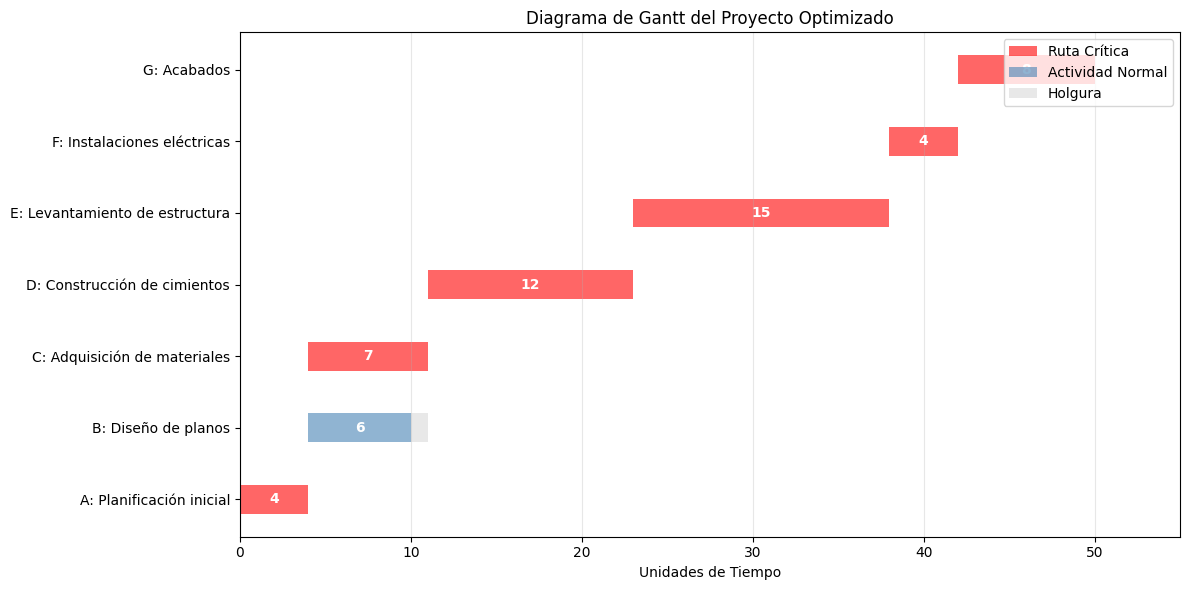

In [ ]:
# ACELERACIÓN DE PROYECTO

class ProjectCompression:
    def __init__(self):
        """Inicializa el objeto de compresión de proyectos"""
        self.activities_df = None
        self.compression_df = None
        self.critical_path = None
        self.total_duration = None
        self.total_normal_cost = 0
        self.total_compression_cost = 0
        self.desired_duration = None
        self.graph = None
        self.early_start = {}
        self.early_finish = {}
        self.late_start = {}
        self.late_finish = {}
        self.slack = {}

    def load_activity_data(self, data):
        """Carga los datos básicos de las actividades"""
        self.activities_df = pd.DataFrame(data, columns=['Activity', 'Description', 'Predecessor', 'Normal Time'])
        self.activities_df['Current Time'] = self.activities_df['Normal Time']
        return self.activities_df

    def load_compression_data(self, data):
        """Carga los datos de compresión de actividades"""
        self.compression_df = pd.DataFrame(data, columns=['Activity', 'Crashed Time', 'Normal Cost', 'Crashed Cost'])
        self.compression_df['Max Reduction'] = self.compression_df.apply(
            lambda row: self.activities_df.loc[self.activities_df['Activity'] == row['Activity'], 'Normal Time'].values[0] - row['Crashed Time'],
            axis=1
        )
        self.compression_df['Current Reduction'] = 0
        self.compression_df['K (Cost/Day)'] = (self.compression_df['Crashed Cost'] - self.compression_df['Normal Cost']) / self.compression_df['Max Reduction']
        self.total_normal_cost = self.compression_df['Normal Cost'].sum()
        return self.compression_df

    def build_network_graph(self):
        """Construye el grafo del proyecto para análisis de ruta crítica"""
        G = nx.DiGraph()

        # Agrega nodos para todas las actividades
        for _, row in self.activities_df.iterrows():
            G.add_node(row['Activity'], time=row['Current Time'])

        # Agrega nodo de inicio y fin
        G.add_node('START', time=0)
        G.add_node('END', time=0)

        # Agrega arcos basados en predecesores
        for _, row in self.activities_df.iterrows():
            if pd.isna(row['Predecessor']) or row['Predecessor'] == '':
                G.add_edge('START', row['Activity'])
            else:
                predecessors = [p.strip() for p in row['Predecessor'].split(',')]
                for pred in predecessors:
                    G.add_edge(pred, row['Activity'])

        # Conecta actividades sin sucesores al nodo final
        for node in G.nodes():
            if node != 'END' and node != 'START':
                if G.out_degree(node) == 0:
                    G.add_edge(node, 'END')

        self.graph = G
        return G

    def calculate_critical_path(self):
        """Calcula la ruta crítica y los tiempos tempranos/tardíos"""
        G = self.graph

        # Calcula tiempos tempranos (forward pass)
        self.early_start = {'START': 0}
        self.early_finish = {'START': 0}

        # Ordenamiento topológico para procesar nodos en orden
        for node in nx.topological_sort(G):
            if node == 'START':
                continue

            # Encuentra el mayor tiempo de finalización temprano de todos los predecesores
            max_pred_finish = 0
            for pred in G.predecessors(node):
                if self.early_finish[pred] > max_pred_finish:
                    max_pred_finish = self.early_finish[pred]

            self.early_start[node] = max_pred_finish

            if node == 'END':
                self.early_finish[node] = max_pred_finish
            else:
                node_time = G.nodes[node].get('time', 0)
                self.early_finish[node] = max_pred_finish + node_time

        # Duración total del proyecto
        self.total_duration = self.early_finish['END']

        # Calcula tiempos tardíos (backward pass)
        self.late_finish = {'END': self.early_finish['END']}
        self.late_start = {'END': self.early_finish['END']}

        # Procesamiento inverso
        for node in reversed(list(nx.topological_sort(G))):
            if node == 'END':
                continue

            # Encuentra el menor tiempo de inicio tardío de todos los sucesores
            min_succ_start = float('inf')
            for succ in G.successors(node):
                if self.late_start[succ] < min_succ_start:
                    min_succ_start = self.late_start[succ]

            if min_succ_start == float('inf'):
                min_succ_start = self.total_duration

            if node == 'START':
                self.late_finish[node] = min_succ_start
                self.late_start[node] = min_succ_start
            else:
                node_time = G.nodes[node].get('time', 0)
                self.late_finish[node] = min_succ_start
                self.late_start[node] = min_succ_start - node_time

        # Calcula holguras
        self.slack = {}
        for node in G.nodes():
            if node not in ['START', 'END']:
                self.slack[node] = self.late_start[node] - self.early_start[node]

        # Identifica la ruta crítica (actividades con holgura = 0)
        self.critical_path = [node for node, slack in self.slack.items() if slack == 0]

        return self.critical_path, self.total_duration

    def get_critical_activities_with_costs(self):
        """Obtiene las actividades críticas ordenadas por costo de compresión por día"""
        critical_activities = []

        for activity in self.critical_path:
            if activity not in ['START', 'END']:
                activity_data = self.compression_df[self.compression_df['Activity'] == activity]

                if not activity_data.empty:
                    remaining_reduction = activity_data['Max Reduction'].values[0] - activity_data['Current Reduction'].values[0]

                    if remaining_reduction > 0:
                        critical_activities.append({
                            'Activity': activity,
                            'K (Cost/Day)': activity_data['K (Cost/Day)'].values[0],
                            'Remaining Reduction': remaining_reduction
                        })

        # Ordena por costo de compresión por día (K)
        critical_activities.sort(key=lambda x: x['K (Cost/Day)'])

        return critical_activities

    def compress_project(self, desired_duration):
        """Comprime el proyecto hasta la duración deseada o hasta que no sea posible comprimir más"""
        self.desired_duration = desired_duration
        compression_steps = []

        current_duration = self.total_duration
        iteration = 1

        while current_duration > desired_duration:
            # Calcula la ruta crítica actual
            self.calculate_critical_path()

            # Obtiene actividades críticas ordenadas por costo
            critical_activities = self.get_critical_activities_with_costs()

            if not critical_activities:
                print(f"No es posible comprimir más allá de {current_duration} unidades de tiempo.")
                break

            # Selecciona la actividad con menor costo de compresión
            best_activity = critical_activities[0]
            activity_id = best_activity['Activity']

            # Comprime la actividad en 1 unidad
            activity_idx = self.activities_df[self.activities_df['Activity'] == activity_id].index[0]
            compression_idx = self.compression_df[self.compression_df['Activity'] == activity_id].index[0]

            # Actualiza tiempo actual
            self.activities_df.at[activity_idx, 'Current Time'] -= 1

            # Actualiza reducción actual
            self.compression_df.at[compression_idx, 'Current Reduction'] += 1

            # Actualiza tiempo en el grafo
            self.graph.nodes[activity_id]['time'] = self.activities_df.at[activity_idx, 'Current Time']

            # Calcula el costo de esta compresión
            compression_cost = self.compression_df.at[compression_idx, 'K (Cost/Day)']
            self.total_compression_cost += compression_cost

            # Recalcula duración total
            self.calculate_critical_path()
            current_duration = self.total_duration

            # Registra el paso de compresión
            compression_steps.append({
                'Iteration': iteration,
                'Activity Compressed': activity_id,
                'Compression Cost': compression_cost,
                'New Duration': current_duration,
                'Critical Path': ', '.join(self.critical_path)
            })

            iteration += 1

        compression_steps_df = pd.DataFrame(compression_steps)
        return compression_steps_df

    def get_final_results(self):
        """Retorna los resultados finales de la compresión"""
        # Calcula la duración normal (la que tendría el proyecto sin compresión)
        self.build_network_graph()  # Reconstruir el grafo con los tiempos normales

        # Restaurar los tiempos normales temporalmente para calcular la duración original
        temp_times = self.activities_df['Current Time'].copy()
        self.activities_df['Current Time'] = self.activities_df['Normal Time']

        # Actualizar tiempos en el grafo
        for _, row in self.activities_df.iterrows():
            activity = row['Activity']
            if activity not in ['START', 'END']:
                self.graph.nodes[activity]['time'] = row['Normal Time']

        # Calcular ruta crítica con tiempos normales
        self.calculate_critical_path()
        original_duration = self.total_duration

        # Restaurar los tiempos actuales
        self.activities_df['Current Time'] = temp_times
        for _, row in self.activities_df.iterrows():
            activity = row['Activity']
            if activity not in ['START', 'END']:
                self.graph.nodes[activity]['time'] = row['Current Time']

        # Recalcular con los tiempos comprimidos
        self.calculate_critical_path()

        results = {
            'Original Duration': original_duration,
            'Compressed Duration': self.total_duration,
            'Original Cost': self.total_normal_cost,
            'Compression Cost': self.total_compression_cost,
            'Final Project Cost': self.total_normal_cost + self.total_compression_cost
        }

        return results

    def get_activity_schedule(self):
        """Obtiene el calendario de actividades con fechas de inicio y fin tempranas/tardías"""
        schedule = []

        for _, row in self.activities_df.iterrows():
            activity = row['Activity']
            if activity not in ['START', 'END']:
                schedule.append({
                    'Activity': activity,
                    'Description': row['Description'],
                    'Normal Time': row['Normal Time'],
                    'Current Time': row['Current Time'],
                    'Early Start': self.early_start.get(activity, 0),
                    'Early Finish': self.early_finish.get(activity, 0),
                    'Late Start': self.late_start.get(activity, 0),
                    'Late Finish': self.late_finish.get(activity, 0),
                    'Slack': self.slack.get(activity, 0),
                    'Is Critical': activity in self.critical_path
                })

        return pd.DataFrame(schedule)

    def generate_gantt_chart(self):
        """Genera un diagrama de Gantt para visualizar el proyecto usando unidades de tiempo"""
        schedule = self.get_activity_schedule()

        # Configura el gráfico
        fig, ax = plt.subplots(figsize=(12, 6))

        # Para cada actividad, dibuja una barra
        y_ticks = []
        y_labels = []

        for i, (_, row) in enumerate(schedule.iterrows()):
            activity_label = f"{row['Activity']}: {row['Description']}"
            y_ticks.append(i)
            y_labels.append(activity_label)

            # Tiempos de inicio y fin
            start = row['Early Start']
            finish = row['Early Finish']

            # Dibuja la barra principal
            color = 'red' if row['Is Critical'] else 'steelblue'
            ax.barh(i, finish - start, left=start, height=0.4, color=color, alpha=0.6)

            # Añade etiqueta de duración
            duration = row['Current Time']
            text_x = start + (finish - start) / 2
            ax.text(text_x, i, f"{duration}", ha='center', va='center', color='white', fontweight='bold')

            # Dibuja la holgura si existe
            if row['Slack'] > 0:
                slack_start = finish
                slack_finish = row['Late Finish']
                ax.barh(i, slack_finish - slack_start, left=slack_start, height=0.4, color='lightgrey', alpha=0.5)

        # Configura los ejes
        ax.set_yticks(y_ticks)
        ax.set_yticklabels(y_labels)
        ax.grid(True, axis='x', alpha=0.3)

        # Formato del eje x como unidades de tiempo
        max_time = max([row['Late Finish'] for _, row in schedule.iterrows()]) + 5
        ax.set_xlim(0, max_time)
        ax.set_xlabel('Unidades de Tiempo')

        # Título y leyenda
        ax.set_title('Diagrama de Gantt del Proyecto Optimizado')

        # Crea una leyenda personalizada
        from matplotlib.patches import Patch
        legend_elements = [
            Patch(facecolor='red', alpha=0.6, label='Ruta Crítica'),
            Patch(facecolor='steelblue', alpha=0.6, label='Actividad Normal'),
            Patch(facecolor='lightgrey', alpha=0.5, label='Holgura')
        ]
        ax.legend(handles=legend_elements, loc='upper right')

        plt.tight_layout()
        return fig

# Ejemplo de uso del código
def run_example():
    # Datos de ejemplo
    activity_data = [
        {'Activity': 'A', 'Description': 'Planificación inicial', 'Predecessor': '', 'Normal Time': 6},
        {'Activity': 'B', 'Description': 'Diseño de planos', 'Predecessor': 'A', 'Normal Time': 8},
        {'Activity': 'C', 'Description': 'Adquisición de materiales', 'Predecessor': 'A', 'Normal Time': 10},
        {'Activity': 'D', 'Description': 'Construcción de cimientos', 'Predecessor': 'B,C', 'Normal Time': 12},
        {'Activity': 'E', 'Description': 'Levantamiento de estructura', 'Predecessor': 'D', 'Normal Time': 15},
        {'Activity': 'F', 'Description': 'Instalaciones eléctricas', 'Predecessor': 'E', 'Normal Time': 6},
        {'Activity': 'G', 'Description': 'Acabados', 'Predecessor': 'F', 'Normal Time': 8}
    ]

    compression_data = [
        {'Activity': 'A', 'Crashed Time': 4, 'Normal Cost': 2000, 'Crashed Cost': 3000},
        {'Activity': 'B', 'Crashed Time': 5, 'Normal Cost': 3000, 'Crashed Cost': 4500},
        {'Activity': 'C', 'Crashed Time': 7, 'Normal Cost': 4000, 'Crashed Cost': 5500},
        {'Activity': 'D', 'Crashed Time': 8, 'Normal Cost': 6000, 'Crashed Cost': 9000},
        {'Activity': 'E', 'Crashed Time': 10, 'Normal Cost': 8000, 'Crashed Cost': 12000},
        {'Activity': 'F', 'Crashed Time': 4, 'Normal Cost': 2500, 'Crashed Cost': 3500},
        {'Activity': 'G', 'Crashed Time': 5, 'Normal Cost': 3000, 'Crashed Cost': 4800}
    ]

    # Crear instancia y cargar datos
    project = ProjectCompression()
    project.load_activity_data(activity_data)
    project.load_compression_data(compression_data)

    # Construir grafo y calcular ruta crítica inicial
    project.build_network_graph()
    critical_path, total_duration = project.calculate_critical_path()

    print(f"Ruta crítica inicial: {critical_path}")
    print(f"Duración total del proyecto: {total_duration} unidades de tiempo")

    # Comprimir el proyecto a 50 unidades de tiempo
    desired_duration = 50
    compression_steps = project.compress_project(desired_duration)

    print("\nPasos de compresión:")
    print(compression_steps)

    # Resultados finales
    results = project.get_final_results()
    print("\nResultados finales:")
    for key, value in results.items():
        print(f"{key}: {value}")

    # Calendario de actividades
    schedule = project.get_activity_schedule()
    print("\nCalendario de actividades:")
    print(schedule)

    # Generar diagrama de Gantt
    fig = project.generate_gantt_chart()
    plt.show()

if __name__ == "__main__":
    run_example()

Tabla de Actividades con Tiempos PERT:
Activity                 Description Predecessor  Optimistic (a)  Most Likely (m)  Pessimistic (b)  Expected Time (TE)  Variance
       A       Planificación inicial                           4                6                8            6.000000  0.444444
       B            Diseño de planos           A               6                8               12            8.333333  1.000000
       C   Adquisición de materiales           A               8               10               14           10.333333  1.000000
       D   Construcción de cimientos         B,C               9               12               18           12.500000  2.250000
       E Levantamiento de estructura           D              12               15               20           15.333333  1.777778
       F    Instalaciones eléctricas           E               4                6               10            6.333333  1.000000
       G                    Acabados           F          

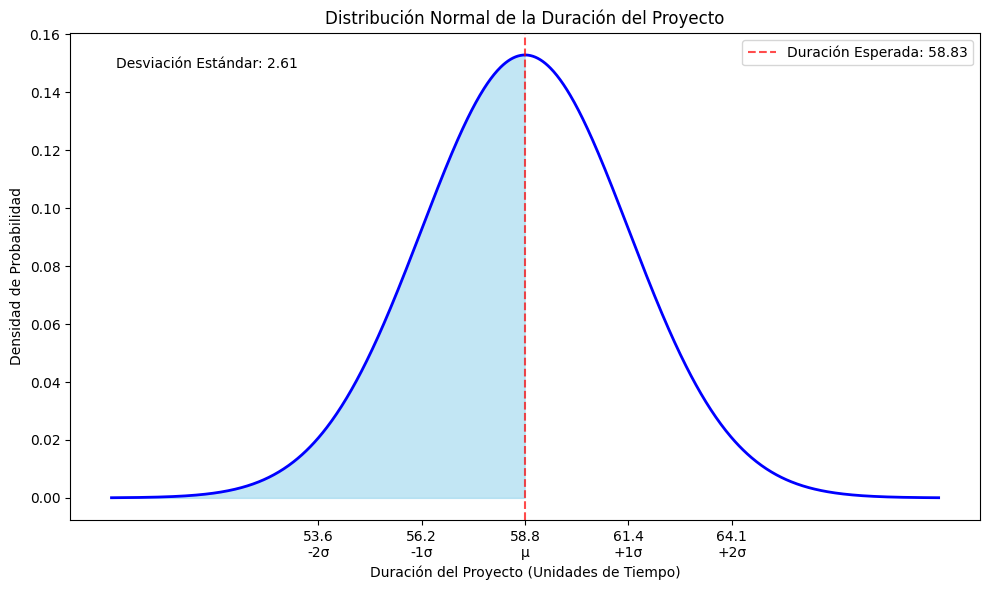

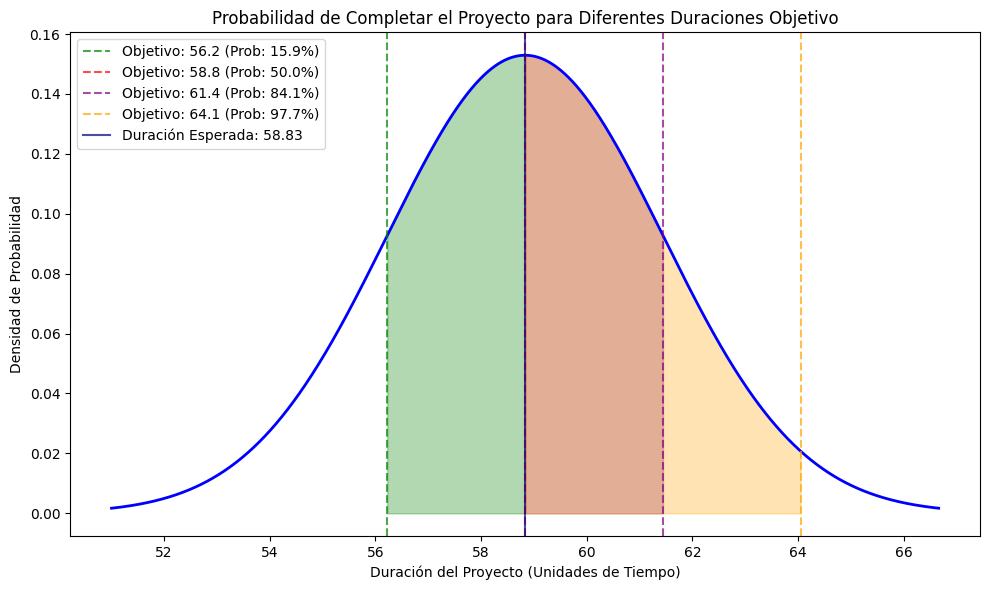

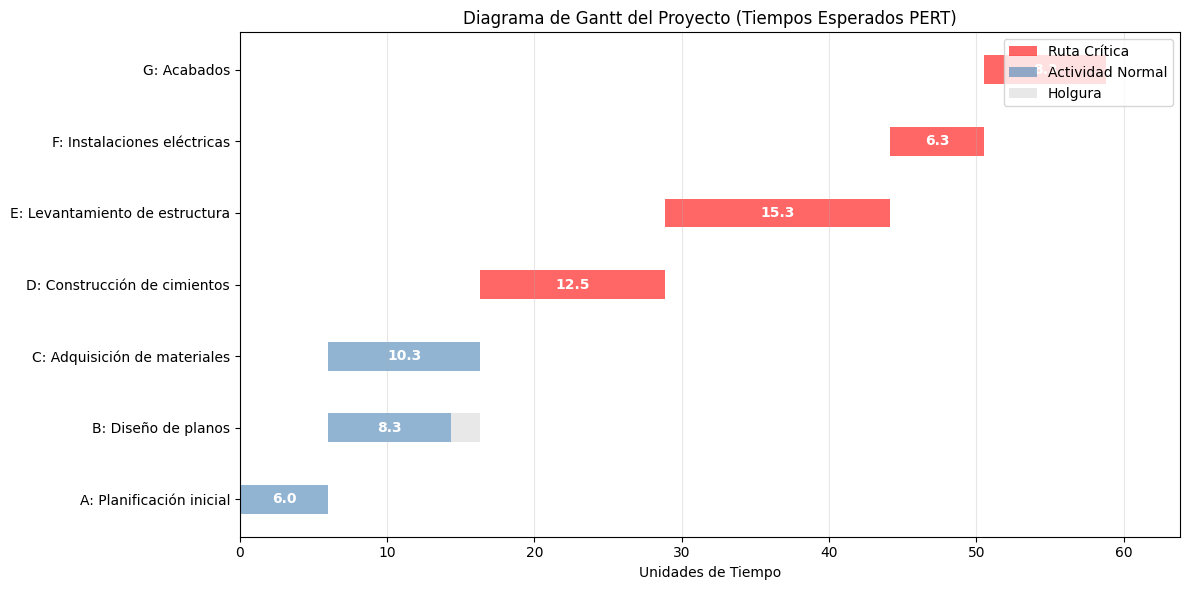

In [ ]:

# PERT ANALYSIS ----

class PERTAnalysis:
    def __init__(self):
        """Inicializa el objeto de análisis PERT"""
        self.activities_df = None
        self.graph = None
        self.critical_path = None
        self.expected_duration = None
        self.variance = None
        self.std_dev = None
        self.early_start = {}
        self.early_finish = {}
        self.late_start = {}
        self.late_finish = {}
        self.slack = {}

    def load_activity_data(self, data):
        """Carga los datos de las actividades con estimaciones optimista, pesimista y más probable"""
        self.activities_df = pd.DataFrame(data, columns=['Activity', 'Description', 'Predecessor',
                                                         'Optimistic (a)', 'Most Likely (m)', 'Pessimistic (b)'])

        # Calcular tiempos esperados (TE) según la fórmula PERT
        self.activities_df['Expected Time (TE)'] = (self.activities_df['Optimistic (a)'] +
                                                   4 * self.activities_df['Most Likely (m)'] +
                                                   self.activities_df['Pessimistic (b)']) / 6

        # Calcular varianza para cada actividad
        self.activities_df['Variance'] = ((self.activities_df['Pessimistic (b)'] -
                                         self.activities_df['Optimistic (a)']) / 6) ** 2

        return self.activities_df

    def build_network_graph(self):
        """Construye el grafo del proyecto para análisis de ruta crítica"""
        G = nx.DiGraph()

        # Agrega nodos para todas las actividades
        for _, row in self.activities_df.iterrows():
            G.add_node(row['Activity'], time=row['Expected Time (TE)'])

        # Agrega nodo de inicio y fin
        G.add_node('START', time=0)
        G.add_node('END', time=0)

        # Agrega arcos basados en predecesores
        for _, row in self.activities_df.iterrows():
            if pd.isna(row['Predecessor']) or row['Predecessor'] == '':
                G.add_edge('START', row['Activity'])
            else:
                predecessors = [p.strip() for p in row['Predecessor'].split(',')]
                for pred in predecessors:
                    G.add_edge(pred, row['Activity'])

        # Conecta actividades sin sucesores al nodo final
        for node in G.nodes():
            if node != 'END' and node != 'START':
                if G.out_degree(node) == 0:
                    G.add_edge(node, 'END')

        self.graph = G
        return G

    def calculate_critical_path(self):
        """Calcula la ruta crítica y los tiempos tempranos/tardíos"""
        G = self.graph

        # Calcula tiempos tempranos (forward pass)
        self.early_start = {'START': 0}
        self.early_finish = {'START': 0}

        # Ordenamiento topológico para procesar nodos en orden
        for node in nx.topological_sort(G):
            if node == 'START':
                continue

            # Encuentra el mayor tiempo de finalización temprano de todos los predecesores
            max_pred_finish = 0
            for pred in G.predecessors(node):
                if self.early_finish[pred] > max_pred_finish:
                    max_pred_finish = self.early_finish[pred]

            self.early_start[node] = max_pred_finish

            if node == 'END':
                self.early_finish[node] = max_pred_finish
            else:
                node_time = G.nodes[node].get('time', 0)
                self.early_finish[node] = max_pred_finish + node_time

        # Duración total esperada del proyecto
        self.expected_duration = self.early_finish['END']

        # Calcula tiempos tardíos (backward pass)
        self.late_finish = {'END': self.early_finish['END']}
        self.late_start = {'END': self.early_finish['END']}

        # Procesamiento inverso
        for node in reversed(list(nx.topological_sort(G))):
            if node == 'END':
                continue

            # Encuentra el menor tiempo de inicio tardío de todos los sucesores
            min_succ_start = float('inf')
            for succ in G.successors(node):
                if self.late_start[succ] < min_succ_start:
                    min_succ_start = self.late_start[succ]

            if min_succ_start == float('inf'):
                min_succ_start = self.expected_duration

            if node == 'START':
                self.late_finish[node] = min_succ_start
                self.late_start[node] = min_succ_start
            else:
                node_time = G.nodes[node].get('time', 0)
                self.late_finish[node] = min_succ_start
                self.late_start[node] = min_succ_start - node_time

        # Calcula holguras
        self.slack = {}
        for node in G.nodes():
            if node not in ['START', 'END']:
                self.slack[node] = self.late_start[node] - self.early_start[node]

        # Identifica la ruta crítica (actividades con holgura = 0)
        self.critical_path = [node for node, slack in self.slack.items() if slack == 0 and node not in ['START', 'END']]

        return self.critical_path, self.expected_duration

    def calculate_project_variance(self):
        """Calcula la varianza del proyecto sumando las varianzas de las actividades en la ruta crítica"""
        total_variance = 0

        for activity in self.critical_path:
            activity_variance = self.activities_df.loc[self.activities_df['Activity'] == activity, 'Variance'].values[0]
            total_variance += activity_variance

        self.variance = total_variance
        self.std_dev = np.sqrt(total_variance)

        return self.variance, self.std_dev

    def calculate_completion_probability(self, target_duration):
        """Calcula la probabilidad de completar el proyecto en o antes de la duración objetivo"""
        # Calcular el valor Z
        z_value = (target_duration - self.expected_duration) / self.std_dev

        # Calcular la probabilidad usando la distribución normal estándar acumulativa
        probability = stats.norm.cdf(z_value)

        return z_value, probability

    def get_activity_schedule(self):
        """Obtiene el calendario de actividades con tiempos tempranos/tardíos y holguras"""
        schedule = []

        for _, row in self.activities_df.iterrows():
            activity = row['Activity']
            if activity not in ['START', 'END']:
                schedule.append({
                    'Activity': activity,
                    'Description': row['Description'],
                    'Optimistic (a)': row['Optimistic (a)'],
                    'Most Likely (m)': row['Most Likely (m)'],
                    'Pessimistic (b)': row['Pessimistic (b)'],
                    'Expected Time (TE)': row['Expected Time (TE)'],
                    'Variance': row['Variance'],
                    'Early Start': self.early_start.get(activity, 0),
                    'Early Finish': self.early_finish.get(activity, 0),
                    'Late Start': self.late_start.get(activity, 0),
                    'Late Finish': self.late_finish.get(activity, 0),
                    'Slack': self.slack.get(activity, 0),
                    'Is Critical': activity in self.critical_path
                })

        return pd.DataFrame(schedule)

    def plot_normal_distribution(self):
        """Grafica la distribución normal de la duración del proyecto"""
        # Crear un rango de valores para graficar
        x = np.linspace(self.expected_duration - 4*self.std_dev,
                         self.expected_duration + 4*self.std_dev, 1000)
        y = stats.norm.pdf(x, self.expected_duration, self.std_dev)

        fig, ax = plt.subplots(figsize=(10, 6))

        # Graficar la curva normal
        ax.plot(x, y, 'b-', linewidth=2)

        # Rellenar el área hasta la media
        ax.fill_between(x, y, where=(x <= self.expected_duration), color='skyblue', alpha=0.5)

        # Línea vertical para la media
        ax.axvline(x=self.expected_duration, color='r', linestyle='--', alpha=0.7,
                  label=f'Duración Esperada: {self.expected_duration:.2f}')

        # Añadir etiquetas y título
        ax.set_xlabel('Duración del Proyecto (Unidades de Tiempo)')
        ax.set_ylabel('Densidad de Probabilidad')
        ax.set_title('Distribución Normal de la Duración del Proyecto')

        # Añadir información sobre la desviación estándar
        ax.text(0.05, 0.95, f'Desviación Estándar: {self.std_dev:.2f}',
                transform=ax.transAxes, fontsize=10, verticalalignment='top')

        # Mostrar leyenda
        ax.legend()

        # Mostrar sigma en el eje x
        sigma_positions = [self.expected_duration - 2*self.std_dev,
                         self.expected_duration - self.std_dev,
                         self.expected_duration,
                         self.expected_duration + self.std_dev,
                         self.expected_duration + 2*self.std_dev]

        sigma_labels = ['-2σ', '-1σ', 'μ', '+1σ', '+2σ']

        ax.set_xticks(sigma_positions)
        ax.set_xticklabels([f'{pos:.1f}\n{label}' for pos, label in zip(sigma_positions, sigma_labels)])

        plt.tight_layout()
        return fig

    def plot_completion_probability(self, target_durations):
        """Grafica la probabilidad de completar el proyecto para diferentes duraciones objetivo"""
        if not isinstance(target_durations, list):
            target_durations = [target_durations]

        # Crear un rango de valores para graficar
        x = np.linspace(self.expected_duration - 3*self.std_dev,
                         self.expected_duration + 3*self.std_dev, 1000)
        y = stats.norm.pdf(x, self.expected_duration, self.std_dev)

        fig, ax = plt.subplots(figsize=(10, 6))

        # Graficar la curva normal
        ax.plot(x, y, 'b-', linewidth=2)

        # Graficar las líneas verticales para cada duración objetivo
        colors = ['g', 'r', 'purple', 'orange', 'brown']
        for i, target in enumerate(target_durations):
            z_value, probability = self.calculate_completion_probability(target)

            # Índice de color (reciclar si hay más objetivos que colores)
            color_idx = i % len(colors)

            # Línea vertical para la duración objetivo
            ax.axvline(x=target, color=colors[color_idx], linestyle='--', alpha=0.7,
                      label=f'Objetivo: {target:.1f} (Prob: {probability:.1%})')

            # Rellenar el área hasta la duración objetivo
            if target > self.expected_duration:
                fill_where = (x >= self.expected_duration) & (x <= target)
            else:
                fill_where = (x >= target) & (x <= self.expected_duration)

            ax.fill_between(x, y, where=fill_where, color=colors[color_idx], alpha=0.3)

        # Línea vertical para la media
        ax.axvline(x=self.expected_duration, color='darkblue', linestyle='-', alpha=0.7,
                  label=f'Duración Esperada: {self.expected_duration:.2f}')

        # Añadir etiquetas y título
        ax.set_xlabel('Duración del Proyecto (Unidades de Tiempo)')
        ax.set_ylabel('Densidad de Probabilidad')
        ax.set_title('Probabilidad de Completar el Proyecto para Diferentes Duraciones Objetivo')

        # Mostrar leyenda
        ax.legend()

        plt.tight_layout()
        return fig

    def generate_gantt_chart(self):
        """Genera un diagrama de Gantt para visualizar el proyecto usando tiempos esperados"""
        schedule = self.get_activity_schedule()

        # Configura el gráfico
        fig, ax = plt.subplots(figsize=(12, 6))

        # Para cada actividad, dibuja una barra
        y_ticks = []
        y_labels = []

        for i, (_, row) in enumerate(schedule.iterrows()):
            activity_label = f"{row['Activity']}: {row['Description']}"
            y_ticks.append(i)
            y_labels.append(activity_label)

            # Tiempos de inicio y fin
            start = row['Early Start']
            finish = row['Early Finish']

            # Dibuja la barra principal
            color = 'red' if row['Is Critical'] else 'steelblue'
            ax.barh(i, finish - start, left=start, height=0.4, color=color, alpha=0.6)

            # Añade etiqueta de duración
            duration = row['Expected Time (TE)']
            text_x = start + (finish - start) / 2
            ax.text(text_x, i, f"{duration:.1f}", ha='center', va='center', color='white', fontweight='bold')

            # Dibuja la holgura si existe
            if row['Slack'] > 0:
                slack_start = finish
                slack_finish = row['Late Finish']
                ax.barh(i, slack_finish - slack_start, left=slack_start, height=0.4, color='lightgrey', alpha=0.5)

        # Configura los ejes
        ax.set_yticks(y_ticks)
        ax.set_yticklabels(y_labels)
        ax.grid(True, axis='x', alpha=0.3)

        # Formato del eje x como unidades de tiempo
        max_time = max([row['Late Finish'] for _, row in schedule.iterrows()]) + 5
        ax.set_xlim(0, max_time)
        ax.set_xlabel('Unidades de Tiempo')

        # Título y leyenda
        ax.set_title('Diagrama de Gantt del Proyecto (Tiempos Esperados PERT)')

        # Crea una leyenda personalizada
        from matplotlib.patches import Patch
        legend_elements = [
            Patch(facecolor='red', alpha=0.6, label='Ruta Crítica'),
            Patch(facecolor='steelblue', alpha=0.6, label='Actividad Normal'),
            Patch(facecolor='lightgrey', alpha=0.5, label='Holgura')
        ]
        ax.legend(handles=legend_elements, loc='upper right')

        plt.tight_layout()
        return fig


# Ejemplo de uso
def run_pert_analysis():
    # Datos de ejemplo
    activity_data = [
        {'Activity': 'A', 'Description': 'Planificación inicial', 'Predecessor': '',
         'Optimistic (a)': 4, 'Most Likely (m)': 6, 'Pessimistic (b)': 8},

        {'Activity': 'B', 'Description': 'Diseño de planos', 'Predecessor': 'A',
         'Optimistic (a)': 6, 'Most Likely (m)': 8, 'Pessimistic (b)': 12},

        {'Activity': 'C', 'Description': 'Adquisición de materiales', 'Predecessor': 'A',
         'Optimistic (a)': 8, 'Most Likely (m)': 10, 'Pessimistic (b)': 14},

        {'Activity': 'D', 'Description': 'Construcción de cimientos', 'Predecessor': 'B,C',
         'Optimistic (a)': 9, 'Most Likely (m)': 12, 'Pessimistic (b)': 18},

        {'Activity': 'E', 'Description': 'Levantamiento de estructura', 'Predecessor': 'D',
         'Optimistic (a)': 12, 'Most Likely (m)': 15, 'Pessimistic (b)': 20},

        {'Activity': 'F', 'Description': 'Instalaciones eléctricas', 'Predecessor': 'E',
         'Optimistic (a)': 4, 'Most Likely (m)': 6, 'Pessimistic (b)': 10},

        {'Activity': 'G', 'Description': 'Acabados', 'Predecessor': 'F',
         'Optimistic (a)': 5, 'Most Likely (m)': 8, 'Pessimistic (b)': 13}
    ]

    # Crear instancia y cargar datos
    pert = PERTAnalysis()
    pert.load_activity_data(activity_data)

    # Mostrar tabla de actividades con tiempos PERT
    print("Tabla de Actividades con Tiempos PERT:")
    activities_table = pert.activities_df[['Activity', 'Description', 'Predecessor',
                                          'Optimistic (a)', 'Most Likely (m)', 'Pessimistic (b)',
                                          'Expected Time (TE)', 'Variance']]
    print(activities_table.to_string(index=False))

    # Construir grafo y calcular ruta crítica
    pert.build_network_graph()
    critical_path, expected_duration = pert.calculate_critical_path()

    print(f"\nRuta Crítica: {critical_path}")
    print(f"Duración Esperada del Proyecto: {expected_duration:.2f} unidades de tiempo")

    # Calcular varianza y desviación estándar del proyecto
    variance, std_dev = pert.calculate_project_variance()
    print(f"\nVarianza del Proyecto: {variance:.2f}")
    print(f"Desviación Estándar del Proyecto: {std_dev:.2f}")

    # Calendario de actividades
    schedule = pert.get_activity_schedule()
    print("\nCalendario de Actividades:")
    print(schedule[['Activity', 'Description', 'Expected Time (TE)', 'Early Start',
                   'Early Finish', 'Late Start', 'Late Finish', 'Slack', 'Is Critical']].to_string(index=False))

    # Calcular probabilidades para diferentes duraciones objetivo
    target_durations = [expected_duration - std_dev, expected_duration,
                        expected_duration + std_dev, expected_duration + 2*std_dev]

    print("\nProbabilidades de Completar el Proyecto:")
    for target in target_durations:
        z_value, probability = pert.calculate_completion_probability(target)
        print(f"Para duración objetivo de {target:.2f}: Z = {z_value:.2f}, Probabilidad = {probability:.2%}")

    # Generar gráficos
    # Distribución normal
    pert.plot_normal_distribution()
    plt.savefig('normal_distribution.png')

    # Probabilidades para diferentes duraciones objetivo
    pert.plot_completion_probability(target_durations)
    plt.savefig('completion_probabilities.png')

    # Diagrama de Gantt
    pert.generate_gantt_chart()
    plt.savefig('gantt_chart.png')

    plt.show()

if __name__ == "__main__":
    run_pert_analysis()